## Thermally driven Convection -pt 2  

Analysis of the convection run, and more advanced behaviour

**New concepts:** Advection-diffusion solver template, thermal boundary conditions, Rayleigh number, analysis functions, interpolation

**NOTE:** I saved all the python setup of the previous notebook in a file so we don't need to type it again. We just do this:


In [1]:
%run "058-RayleighBenardConvection-setup.py"


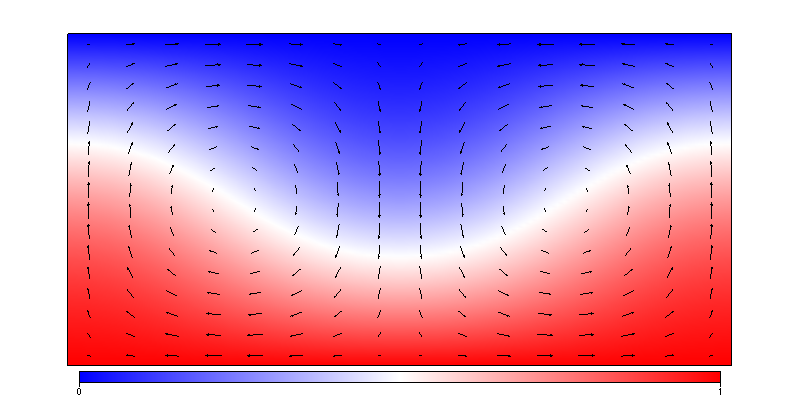

10000.0


In [2]:
# Ready ?

solver.solve()

# plot figure 

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()

print Ra

# (YES !)

## Functions

Underworld defines a special class of parallel-safe, _lazy_ functions. These are used by the finite element routines to build viscosity, buoyancy etc at all the sample points in the domain. They are only evaluated when needed (hence *lazy*) and it is the **definition** which we store, not the values. This is important ... 

The buoyancy function is a uw vector function, so is the temperature (why ?):

``` python
# Rayleigh number.
Ra = 1.0e4

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

```

Watch this:

In [3]:
## Buoyancy Function and lazy evaluation


location = (1.0,0.0)

print Ra
print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)


Ra = 1.0e8

print Ra
print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

10000.0
[[     0.  10000.]]
[[ 1.]]
100000000.0
[[     0.  10000.]]
[[ 1.]]


An alternative way to do this is to use the `constant` function which is more like a parameter-setting function.

In [4]:
# Rayleigh number.
Ra = fn.misc.constant(1.0e4)

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

Ra.value = 1.0e8

print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

[[     0.  10000.]]
[[ 1.]]
[[  0.00000000e+00   1.00000000e+08]]
[[ 1.]]


This saves us from having to rebuild the buoyancy force term and re-load it into the template every time we need to change the Rayleigh number. 

**NOTE:** if we want to use this now, we have to reload it into the template !!

In [5]:
stokes.fn_bodyforce = buoyancyFn

We can see if that worked ... 

**Plot final temperature and velocity field**

In [6]:
# Global max min

print fn.view.min_max(temperatureField)

# This is a function that will return the global max / min of the function's last evaluation
# THIS HAS to be done in two steps: evaluate, then ask for max / min

T_maxmin_fn = fn.view.min_max(temperatureField)
T_maxmin_fn.evaluate(mesh)

print T_maxmin_fn.min_global(), T_maxmin_fn.max_global()


0.0 1.0


**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer. In the R-B convection example, that means 

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


In [7]:
nuNumerator    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuDenominator  = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]

print Nusselt

1.0


The root mean squared velocity is defined by integrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $dV$ denotes an elemental volume (area) of the box.



In [8]:
int_vdotv_dV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), mesh )
int_1_dV     = uw.utils.Integral( 1.0 , mesh )

Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]

print "Volume (Area) of the mesh = ", int_1_dV.evaluate()[0]
print "Vrms = ", Vrms

Volume (Area) of the mesh =  2.0
Vrms =  1254.70345877


## Exercise - role of aspect ratio on convection

Compute the Nusselt / Vrms values for one Ra but different aspect ratio.
At an Ra of $10^4$ a perturbation to the initial geometry can create a
stable set of 1, 2 or 3 cells. 

How does this influence the Vrms / Nu ?


In [20]:
Ra.value = 1.0e4
cells = 2.0

In [21]:
pertStrength = 0.2

deltaTemp = tempMax - tempMin

for index, coord in enumerate(Tmesh.data):
    pertCoeff = math.cos( cells / 2.0 * math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

for index in Tmesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
    
for index in Tmesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin


In [22]:
glucifer_filename = "Ra-Escalating"
store = glucifer.Store(filename=glucifer_filename)
frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh, temperatureField, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=1.0/Ra.value) )

In [23]:
def Vrms_fn():
    Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]
    return Vrms

def Nu_fn():
    Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]
    return Nusselt


In [24]:
time = 0.
step = 0
steps_end = 500

Nusselt_t = np.empty(steps_end*4)
Vrms_t = np.empty(steps_end*4)
times_t = np.empty(steps_end*4)

for RayleighNo in [1.0e3, 1.0e4, 3.1e4, 1.0e5]:
    
    Ra.value = RayleighNo
    step_1 = 0

    while step_1 < steps_end:
        # Solve for the velocity field given the current temperature field.
        solver.solve()
        # Retrieve the maximum possible timestep for the AD system.
        dt = advDiff.get_max_dt()
        if step == 0:
            dt = 0.
        # Advect using this timestep size   
        advDiff.integrate(dt)  ## <- The explicit timestep computations

        time += dt

        Nusselt_t[step] = Nu_fn()
        Vrms_t[step] = Vrms_fn()
        times_t[step] = time

        if step%5 == 0:
            store.step=step
            frames.save()
            print("Ra: {}/Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(RayleighNo, step, times_t[step],
                                                                            Nusselt_t[step], Vrms_t[step] ))

        step += 1
        step_1 += 1
        
        


    

Ra: 1000.0/Step = 0 | time = 0.0 | Nusselt = 1.0 | Vrms = 12.5470345877
Ra: 1000.0/Step = 5 | time = 0.009765625 | Nusselt = 1.08190157443 | Vrms = 13.5349992138
Ra: 1000.0/Step = 10 | time = 0.01953125 | Nusselt = 1.14658014693 | Vrms = 14.6331822724
Ra: 1000.0/Step = 15 | time = 0.029296875 | Nusselt = 1.19635409351 | Vrms = 15.5989496932
Ra: 1000.0/Step = 20 | time = 0.0390625 | Nusselt = 1.23541774957 | Vrms = 16.4491806881
Ra: 1000.0/Step = 25 | time = 0.048828125 | Nusselt = 1.26653318422 | Vrms = 17.1995431476
Ra: 1000.0/Step = 30 | time = 0.05859375 | Nusselt = 1.29171081222 | Vrms = 17.8635868834
Ra: 1000.0/Step = 35 | time = 0.068359375 | Nusselt = 1.31240728468 | Vrms = 18.4526526236
Ra: 1000.0/Step = 40 | time = 0.078125 | Nusselt = 1.32967372362 | Vrms = 18.9761221228
Ra: 1000.0/Step = 45 | time = 0.087890625 | Nusselt = 1.34426898257 | Vrms = 19.4417680123
Ra: 1000.0/Step = 50 | time = 0.09765625 | Nusselt = 1.35674414075 | Vrms = 19.8560935317
Ra: 1000.0/Step = 55 | time

Ra: 1000.0/Step = 455 | time = 0.888671875 | Nusselt = 1.4420827411 | Vrms = 22.8870723733
Ra: 1000.0/Step = 460 | time = 0.8984375 | Nusselt = 1.44208278338 | Vrms = 22.8870737298
Ra: 1000.0/Step = 465 | time = 0.908203125 | Nusselt = 1.44208281925 | Vrms = 22.8870748818
Ra: 1000.0/Step = 470 | time = 0.91796875 | Nusselt = 1.44208284985 | Vrms = 22.8870758615
Ra: 1000.0/Step = 475 | time = 0.927734375 | Nusselt = 1.44208287575 | Vrms = 22.8870766933
Ra: 1000.0/Step = 480 | time = 0.9375 | Nusselt = 1.44208289794 | Vrms = 22.8870774008
Ra: 1000.0/Step = 485 | time = 0.947265625 | Nusselt = 1.44208291667 | Vrms = 22.8870780013
Ra: 1000.0/Step = 490 | time = 0.95703125 | Nusselt = 1.44208293261 | Vrms = 22.8870785104
Ra: 1000.0/Step = 495 | time = 0.966796875 | Nusselt = 1.4420829462 | Vrms = 22.8870789445
Ra: 10000.0/Step = 500 | time = 0.975065842536 | Nusselt = 1.48617390344 | Vrms = 2288.7079313
Ra: 10000.0/Step = 505 | time = 0.977005614234 | Nusselt = 2.01190227799 | Vrms = 3936.4

Ra: 10000.0/Step = 890 | time = 1.14919340555 | Nusselt = 4.48309626778 | Vrms = 1833.51333434
Ra: 10000.0/Step = 895 | time = 1.15143453111 | Nusselt = 4.48566195156 | Vrms = 1834.88482946
Ra: 10000.0/Step = 900 | time = 1.15367510405 | Nusselt = 4.4879567204 | Vrms = 1835.29043979
Ra: 10000.0/Step = 905 | time = 1.15591561234 | Nusselt = 4.4897798066 | Vrms = 1834.82811192
Ra: 10000.0/Step = 910 | time = 1.15815647954 | Nusselt = 4.49100889475 | Vrms = 1833.6729719
Ra: 10000.0/Step = 915 | time = 1.1603980303 | Nusselt = 4.49160160551 | Vrms = 1832.0474636
Ra: 10000.0/Step = 920 | time = 1.1626404709 | Nusselt = 4.49158839489 | Vrms = 1830.19085391
Ra: 10000.0/Step = 925 | time = 1.16488388478 | Nusselt = 4.49105881976 | Vrms = 1828.33151409
Ra: 10000.0/Step = 930 | time = 1.16712824152 | Nusselt = 4.49014356507 | Vrms = 1826.66452812
Ra: 10000.0/Step = 935 | time = 1.16937341629 | Nusselt = 4.48899473507 | Vrms = 1825.33618425
Ra: 10000.0/Step = 940 | time = 1.17161921654 | Nusselt 

Ra: 31000.0/Step = 1320 | time = 1.25981049615 | Nusselt = 6.01300619233 | Vrms = 8243.11848719
Ra: 31000.0/Step = 1325 | time = 1.26077443213 | Nusselt = 6.01971965381 | Vrms = 8309.24588991
Ra: 31000.0/Step = 1330 | time = 1.26173534804 | Nusselt = 6.0287482769 | Vrms = 8368.41795814
Ra: 31000.0/Step = 1335 | time = 1.26269370061 | Nusselt = 6.039189362 | Vrms = 8416.96315479
Ra: 31000.0/Step = 1340 | time = 1.26365007959 | Nusselt = 6.05013530676 | Vrms = 8452.38518177
Ra: 31000.0/Step = 1345 | time = 1.26460514833 | Nusselt = 6.0607398115 | Vrms = 8473.45556549
Ra: 31000.0/Step = 1350 | time = 1.26555958717 | Nusselt = 6.07026912279 | Vrms = 8480.1805089
Ra: 31000.0/Step = 1355 | time = 1.2665140432 | Nusselt = 6.07814442756 | Vrms = 8473.66238004
Ra: 31000.0/Step = 1360 | time = 1.26746908893 | Nusselt = 6.08396807976 | Vrms = 8455.88073356
Ra: 31000.0/Step = 1365 | time = 1.26842519122 | Nusselt = 6.0875349324 | Vrms = 8429.4284984
Ra: 31000.0/Step = 1370 | time = 1.26938269081 |

Ra: 100000.0/Step = 1750 | time = 1.3156549958 | Nusselt = 7.59733220737 | Vrms = 42503.4733165
Ra: 100000.0/Step = 1755 | time = 1.31605668503 | Nusselt = 7.65789125247 | Vrms = 43332.1111807
Ra: 100000.0/Step = 1760 | time = 1.3164561471 | Nusselt = 7.71605162442 | Vrms = 43818.4963607
Ra: 100000.0/Step = 1765 | time = 1.31685473472 | Nusselt = 7.76874661917 | Vrms = 43950.5327773
Ra: 100000.0/Step = 1770 | time = 1.31725376056 | Nusselt = 7.81346949983 | Vrms = 43741.0405943
Ra: 100000.0/Step = 1775 | time = 1.31765443903 | Nusselt = 7.84836145377 | Vrms = 43227.9451668
Ra: 100000.0/Step = 1780 | time = 1.31805782277 | Nusselt = 7.87225027399 | Vrms = 42470.6689261
Ra: 100000.0/Step = 1785 | time = 1.31846474373 | Nusselt = 7.88465616599 | Vrms = 41543.0751532
Ra: 100000.0/Step = 1790 | time = 1.3188757682 | Nusselt = 7.88576535444 | Vrms = 40524.5279622
Ra: 100000.0/Step = 1795 | time = 1.31929117378 | Nusselt = 7.87639413193 | Vrms = 39490.9282829
Ra: 100000.0/Step = 1800 | time =

In [25]:
%%sh

ls *.gldb

Ra-Escalating.gldb
Ra1e4-1cell.gldb
Rayleigh-1e4-1cell.gldb
Rayleigh-1e6.gldb


In [26]:
view = glucifer.lavavu.Viewer(database="{}.gldb".format(glucifer_filename))
# print(view.steps)

view.control.Panel()
view.control.Checkbox(property='axis')
view.control.ObjectList()
view.control.TimeStepper()
view.control.show()

<IPython.core.display.Javascript object>

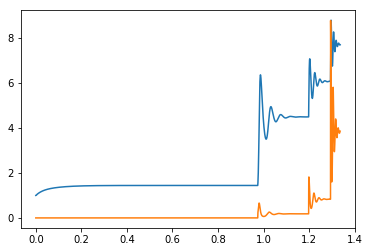

In [27]:
## Make a plot of Nu / Vrms against time

%matplotlib inline

from matplotlib import pyplot as plt

graph = plt.Figure(figsize=(10,5))
ax = plt.subplot(111)
# ax.set_ylim(3.8,4.4)
ax.plot(times_t, Nusselt_t)
ax.plot(times_t, Vrms_t*0.0001)




In [ ]:
print("Nusselt_no at final state - {}".format(Nusselt_t[-1]))
print("Vrms at final state - {}".format(Vrms_t[-1]))